In [1]:
from google.colab import drive
drive=drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 41.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
import warnings
import os
import random
import shutil
import csv

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [4]:
metadata=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/QuantumBlack/metadata.csv")
print(len(metadata))
metadata.head(5)

430


,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,31.528750,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...
1,20230103,id_2542,yes,train,35.538000,112.524000,42,37,images/plume/20230103_methane_mixing_ratio_id_...
2,20230301,id_6546,yes,train,21.060000,84.936667,58,15,images/plume/20230301_methane_mixing_ratio_id_...
3,20230225,id_6084,yes,train,26.756667,80.973333,28,62,images/plume/20230225_methane_mixing_ratio_id_...
4,20230105,id_2012,yes,train,34.800000,40.770000,59,44,images/plume/20230105_methane_mixing_ratio_id_...


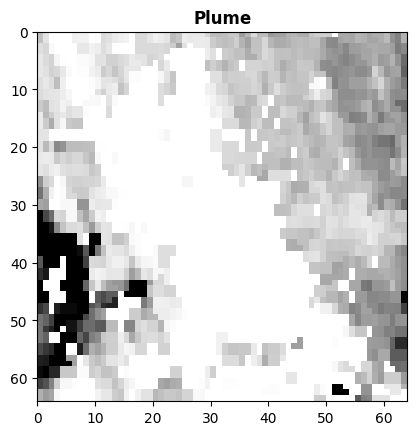

<Axes: title={'center': 'Plume'}>

In [5]:
img_dir_no_plume = '/content/drive/MyDrive/Colab Notebooks/QuantumBlack/images/no_plume/'
img_dir_plume = '/content/drive/MyDrive/Colab Notebooks/QuantumBlack/images/plume/'
# show an image example
path = img_dir_plume+"20230212_methane_mixing_ratio_id_4447.tif"
path2 = img_dir_no_plume+"20230124_methane_mixing_ratio_id_6658.tif"
example_image = rasterio.open(path)#plume
example_image2 = rasterio.open(path2)#no plume
show(example_image, cmap="Greys", title="Plume")

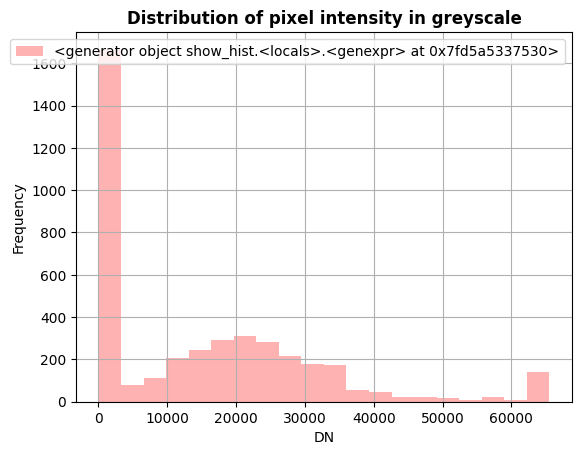

In [6]:
# pixel intensity 
show_hist(example_image, bins=20, alpha=0.3, title="Distribution of pixel intensity in greyscale")

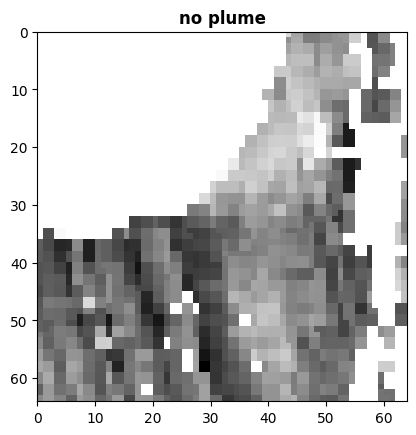

<Axes: title={'center': 'no plume'}>

In [7]:
show(example_image2, cmap="Greys", title='no plume')

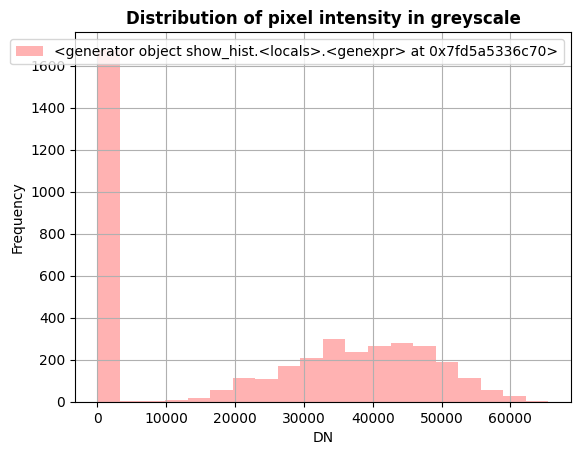

In [8]:
show_hist(example_image2, bins=20, alpha=0.3, title="Distribution of pixel intensity in greyscale")

Prepare Train and test dataset

In [10]:
random.seed(42)
train_dir = '/content/drive/MyDrive/Colab Notebooks/QuantumBlack/train/'
test_dir = '/content/drive/MyDrive/Colab Notebooks/QuantumBlack/test/'

# Delete train and test directories if they already exist
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Create the train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
train_list=[]
test_list=[]
split_ratio = 0.8


prefix = '0'

# put no plume images to the train/test folder
for file_name in os.listdir(img_dir_no_plume):
    src_path = os.path.join(img_dir_no_plume, file_name)
    if random.random() < split_ratio:
        dst_path = os.path.join(train_dir, prefix + file_name)
        train_list.append('images/no_plume/' + file_name)
    else:
        dst_path = os.path.join(test_dir, prefix + file_name)
        test_list.append('images/no_plume/' + file_name)
    shutil.copy(src_path, dst_path)
    
prefix2 = '1'
# put plume images to the train/test folder
for file_name in os.listdir(img_dir_plume):
    src_path = os.path.join(img_dir_plume, file_name)
    if random.random() < split_ratio:
        dst_path = os.path.join(train_dir, prefix2 + file_name)
        train_list.append('images/plume/' +file_name)
    else:
        dst_path = os.path.join(test_dir, prefix2 + file_name)
        test_list.append('images/plume/' +file_name)
    shutil.copy(src_path, dst_path)

In [11]:
print('train size:',len(train_list))
print('test size:',len(test_list))

train size: 333
test size: 95


In [12]:
from sklearn.preprocessing import MinMaxScaler


# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the 'lat' and 'lon' columns
scaled_values = scaler.fit_transform(metadata[['lat', 'lon']])

# Create a new DataFrame with the normalized values
df_normalized = metadata.copy()
df_normalized[['lat', 'lon']] = scaled_values
df_normalized

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,0.680823,0.776640,24,47,images/plume/20230223_methane_mixing_ratio_id_...
1,20230103,id_2542,yes,train,0.715369,0.933406,42,37,images/plume/20230103_methane_mixing_ratio_id_...
2,20230301,id_6546,yes,train,0.590616,0.820173,58,15,images/plume/20230301_methane_mixing_ratio_id_...
3,20230225,id_6084,yes,train,0.639702,0.803905,28,62,images/plume/20230225_methane_mixing_ratio_id_...
4,20230105,id_2012,yes,train,0.709010,0.638888,59,44,images/plume/20230105_methane_mixing_ratio_id_...
...,...,...,...,...,...,...,...,...,...
425,20230302,id_6658,no,train,0.675970,0.613322,39,36,images/no_plume/20230302_methane_mixing_ratio_...
426,20230218,id_4690,no,train,0.718922,0.636826,29,28,images/no_plume/20230218_methane_mixing_ratio_...
427,20230213,id_2519,no,train,0.839673,0.496243,23,10,images/no_plume/20230213_methane_mixing_ratio_...
428,20230213,id_5510,no,train,0.691034,0.654647,55,54,images/no_plume/20230213_methane_mixing_ratio_...


In [13]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for file in train_list:
  train_df=pd.concat([train_df, df_normalized[df_normalized['path']==file[0:-4]]])
for file in test_list:
  test_df=pd.concat([test_df, df_normalized[df_normalized['path']==file[0:-4]]])

So now we have train_dir and test_dir to store train and test imgs while train_df and test_df to store imformation of train and test imgs.

In [14]:
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import cv2

# Set the image size
img_width = 64
img_height = 64
img_size=(64,64)
X_train=[]
y_train=[]
for img_name in os.listdir('/content/drive/MyDrive/Colab Notebooks/QuantumBlack/train'):
        img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/QuantumBlack/train', img_name)
        img = rasterio.open(img_path)
        data = img.read().transpose(1, 2, 0)
        data = cv2.resize(data, img_size)
        data = np.expand_dims(data, axis=-1)
        data = data.astype('float32') / 255.0
        X_train.append(np.array(data))
        if img_name[0]=='1':
          y_train.append(1)
        else:
          y_train.append(0)

X_test=[]
y_test=[]
for img_name in os.listdir('/content/drive/MyDrive/Colab Notebooks/QuantumBlack/test'):
        img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/QuantumBlack/test', img_name)
        img = rasterio.open(img_path)
        data = img.read().transpose(1, 2, 0)
        data = cv2.resize(data, img_size)
        data = np.expand_dims(data, axis=-1)
        data = data.astype('float32') / 255.0
        X_test.append(np.array(data))
        if img_name[0]=='1':
          y_test.append(1)
        else:
          y_test.append(0)


## model without the geodata

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os


# Create a TensorFlow dataset object
batch_size=2
train_data, val_data, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=img_size+(1,)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_dataset, epochs=15, validation_data=train_dataset)

#  validation_data=test_dataset)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

Epoch 1/15
167/167 [==============================] - 7s 34ms/step - loss: 15.9642 - accuracy: 0.9760 - val_loss: 105.3439 - val_accuracy: 0.4925
Epoch 2/15
167/167 [==============================] - 7s 43ms/step - loss: 9.7804 - accuracy: 0.5315 - val_loss: 0.6896 - val_accuracy: 0.5165
Epoch 3/15
167/167 [==============================] - 6s 36ms/step - loss: 0.6141 - accuracy: 0.6697 - val_loss: 0.6771 - val_accuracy: 0.5556
Epoch 4/15
167/167 [==============================] - 6s 33ms/step - loss: 0.5387 - accuracy: 0.7868 - val_loss: 0.5982 - val_accuracy: 0.6667
Epoch 5/15
167/167 [==============================] - 7s 40ms/step - loss: 0.4402 - accuracy: 0.7958 - val_loss: 0.4075 - val_accuracy: 0.8318
Epoch 6/15
167/167 [==============================] - 6s 36ms/step - loss: 0.3494 - accuracy: 0.8709 - val_loss: 0.3108 - val_accuracy: 0.8679
Epoch 7/15
167/167 [==============================] - 6s 36ms/step - loss: 0.2546 - accuracy: 0.9099 - val_loss: 0.2040 - val_accuracy: 0.9

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Evaluate the model on the test dataset and get the predicted probabilities
y_pred_prob = model.predict(test_dataset)
y_pred = (y_pred_prob >= 0.5).astype(int)
y_scores = y_pred.flatten()

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_scores)
print(f"AUC score: {auc_score:.2f}")


48/48 [==============================] - 0s 5ms/step
AUC score: 0.71


In [45]:
y_scores

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1])

## model with geodata

In [15]:
## extract the geodata
train_df = train_df.drop_duplicates(subset=['path'])

loc_train = np.array([list(loc) for loc in zip(train_df['lat'], train_df['lon'],train_df['coord_x'],train_df['coord_y'])])

In [33]:
## add the location data into the model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


img_inputs = keras.Input(shape=(64, 64, 1),name = 'img')

location_inputs = keras.Input(shape=(4,), name='location')

# Reshape location_inputs to match the shape of img_inputs
reshaped_location_inputs = layers.Reshape((1, 1, 4))(location_inputs)
tiled_location_inputs = layers.UpSampling2D((64, 64))(reshaped_location_inputs)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([tiled_location_inputs, img_inputs])

x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid', name = 'plume')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[location_inputs, img_inputs],
    outputs = output,
)

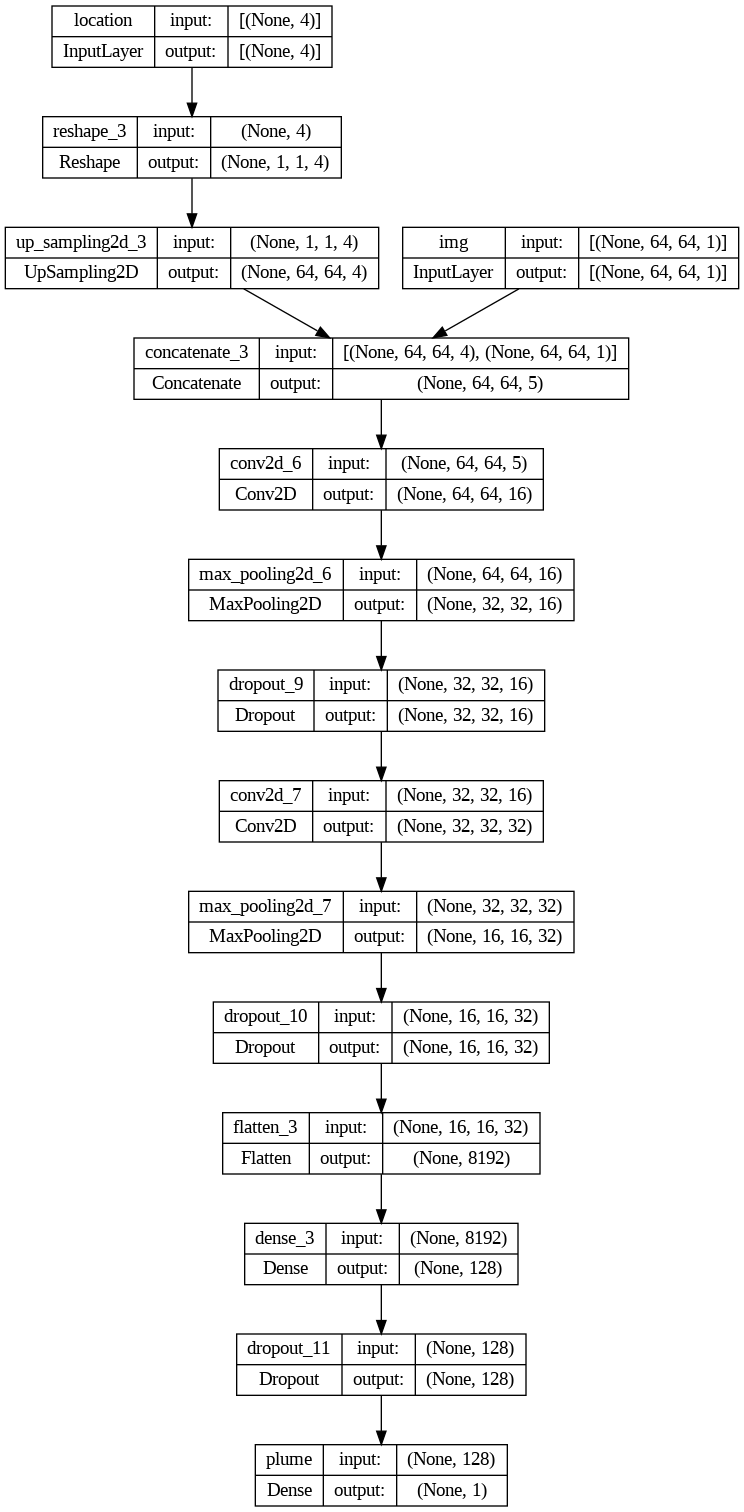

In [34]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# input data
img_data = np.array(X_train)
loc_data = loc_train

# target data
targets_train = np.array(y_train)

# Split the data into training and validation sets
loc_data_train, loc_data_val, img_data_train, img_data_val, targets_train, targets_val = train_test_split(
    loc_data, img_data, targets_train, test_size=0.2, random_state=42
)

history = model.fit(
    {"location": loc_data_train, "img": img_data_train},
    {"plume": targets_train},
    epochs=30,
    batch_size=2,
    validation_data=(
        {"location": loc_data_val, "img": img_data_val},
        {"plume": targets_val}
    )
)

Epoch 1/30
133/133 [==============================] - 6s 28ms/step - loss: 12.1349 - accuracy: 0.6165 - val_loss: 0.5718 - val_accuracy: 0.7612
Epoch 2/30
133/133 [==============================] - 3s 25ms/step - loss: 0.5520 - accuracy: 0.7406 - val_loss: 0.5118 - val_accuracy: 0.7910
Epoch 3/30
133/133 [==============================] - 4s 33ms/step - loss: 0.3571 - accuracy: 0.8759 - val_loss: 0.6189 - val_accuracy: 0.7910
Epoch 4/30
133/133 [==============================] - 4s 29ms/step - loss: 0.2584 - accuracy: 0.8910 - val_loss: 0.5540 - val_accuracy: 0.7910
Epoch 5/30
133/133 [==============================] - 3s 25ms/step - loss: 0.1920 - accuracy: 0.9361 - val_loss: 0.6095 - val_accuracy: 0.7164
Epoch 6/30
133/133 [==============================] - 4s 27ms/step - loss: 0.2178 - accuracy: 0.9023 - val_loss: 0.5283 - val_accuracy: 0.7612
Epoch 7/30
133/133 [==============================] - 5s 35ms/step - loss: 0.1007 - accuracy: 0.9624 - val_loss: 0.6941 - val_accuracy: 0.776

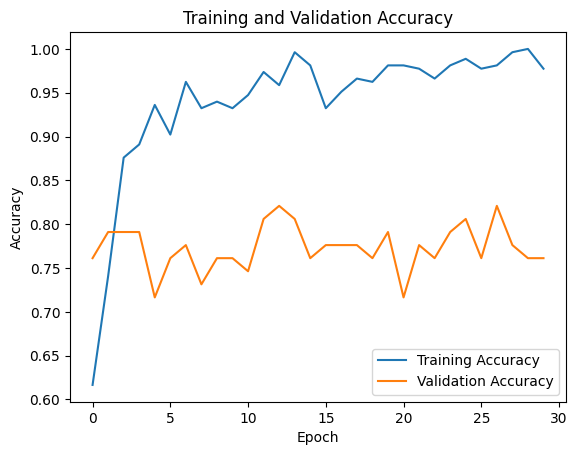

In [39]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc="lower right")
plt.show()

In [37]:
loc_test =  np.array([list(lat_lon) for lat_lon in zip(test_df['lat'], test_df['lon'],test_df['coord_x'],test_df['coord_y'])])

img_data = np.array(X_test)
loc_data = loc_test

# target data
targets_test = np.array(y_test)

# Evaluate the model
test_loss, test_acc = model.evaluate({"location": loc_data, "img": img_data},
    {"plume": targets_test})
print(test_acc)

3/3 [==============================] - 0s 92ms/step - loss: 0.8323 - accuracy: 0.8421
0.8421052694320679


3/3 [==============================] - 0s 40ms/step
AUC score: 0.85


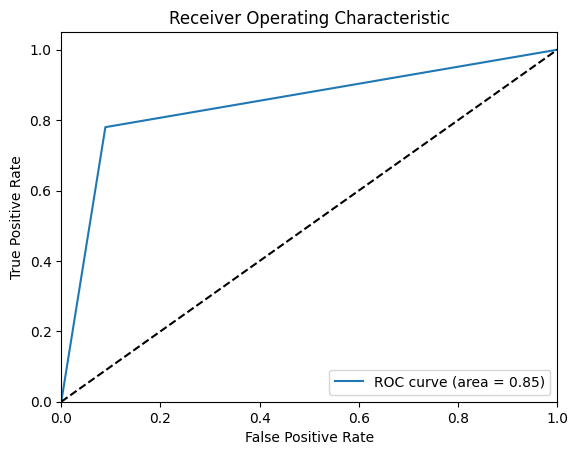

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Evaluate the model on the test dataset and get the predicted probabilities
y_pred_prob = model.predict({"location": loc_data, "img": img_data})
y_pred = (y_pred_prob >= 0.5).astype(int)
y_scores = y_pred.flatten()

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_scores)
print(f"AUC score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [66]:
y_scores

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [63]:

# Save the entire model
model.save('model.h5')


In [64]:
# Save the model architecture as JSON
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)